In [1]:
print("Bismillahir Rahmanir Rahim")

Bismillahir Rahmanir Rahim


## Imports and Paths

In [418]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pathlib
import numpy as np
# https://pypi.org/project/opencv-python/
# https://opencv.org/
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import feature, transform
from scipy.stats import mode

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

# 1. Deep Learning Model

## Load and preprocess data

Train/test split = 0.80/0.20

In [266]:
project_path = pathlib.Path.cwd().parent.parent.parent
generate_csv_path = str(project_path) + '/datasets/generated_csvs/'
plots_path = str(project_path) + '/plots/'
# print(project_path)

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Train and evaluate deep learning model

In [5]:
batch_size = 128
num_classes = 10
epochs = 1

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 60s 999us/step - loss: 0.2459 - acc: 0.9242 - val_loss: 0.0517 - val_acc: 0.9824
Test loss: 0.05165797256581718
Test accuracy: 0.9824


In [ ]:
# image_index = 44
# plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
# pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
# print(pred)
# print(pred.argmax())

# 2. Explanation Models

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [591]:
def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    if cmap == 'Greys':
        axis.imshow(data, cmap=cmap)
    if cmap == 'viridis':
        axis.imshow(data, cmap=cmap)
    else:
        axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

## Define neighbohood 

In [11]:
def neighbourhood_images(x_test, y_test, digit):
    ## Find similar digit images to use as neighbourhood
    indices = []
    index = 0
    for label_array in y_test:
        label = np.argmax(label_array)
        if label == digit:
            indices.append(index)
        index = index +1
    x_test_neighborhood = x_test[indices]
    y_test_neighborhood = y_test[indices]
    return x_test_neighborhood, y_test_neighborhood

In [280]:
digit = 3
anchor_index = 0
x_test_neighborhood, y_test_neighborhood = neighbourhood_images(x_test, y_test, digit)
print(y_test_neighborhood[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Interpreting models using DeepExplain

In [309]:
%%time
""" This block is used for original images
"""
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test_neighborhood
    ys = y_test_neighborhood
    
    attributions_sal = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print('Digit ', digit)
    print ("Done")

Digit  3
Done
CPU times: user 12min 59s, sys: 2min 25s, total: 15min 24s
Wall time: 2min 45s


### Explanation calculation time

- Digit 3: CPU times: user 12min 43s, sys: 2min 25s, total: 15min 9s, Wall time: 2min 43s

- Digit  7: CPU times: user 13min 30s, sys: 2min 31s, total: 16min 2s, Wall time: 2min 50s

### Measuring stability using lipschitz estimation

In [246]:
def euclidean_distances(x0, Xs):
    distances = []
    for image in Xs:
        df = np.asarray(x0 - image)  # the difference between the images
        dst = np.sqrt(np.sum(df**2))
        distances.append(dst)
    return distances

In [515]:
def lipschitz_estimation(anchor_index, x_neighborhood, x_test_neighborhood_exp):
    
    neighborhood_size = len(x_neighborhood)
    filter_indices = np.arange(0, neighborhood_size)
    filter_indices = np.delete(filter_indices, anchor_index)
    
    anchorX = x_neighborhood[anchor_index]
    anchorX_exp = x_test_neighborhood_exp[anchor_index]
    
    nearby_points = x_neighborhood[filter_indices]
    nearby_points_exp = x_test_neighborhood_exp[filter_indices]

    anchorX_norm2 = euclidean_distances(anchorX, nearby_points)
    anchorX_exp_norm2 = euclidean_distances(anchorX_exp, nearby_points_exp)

    anchorX_avg_norm2 = np.divide(anchorX_exp_norm2, anchorX_norm2)
    anchorX_LC_argmax = np.argmax(anchorX_avg_norm2)
    print(anchorX_avg_norm2)
    
    return anchorX_LC_argmax, anchorX_avg_norm2, nearby_points, nearby_points_exp

In [516]:
col_lipschitz = ['digit','image_instance','anchor_index','neighborhood_size',
                 'image_instance_exp', 'deviation_indices', 'lc_coefficents',
                 'deviation_image_instances', 'deviation_image_instance_exp']

In [517]:
def lipschitz_estimates_to_dataframe(explanations_data, x_neighborhood):
    
    digits = []
    image_instance  = []
    anchor_indices  = []
    neighborhood_size = []
    image_instance_exp = dict()
    deviation_indices = dict()
    lc_coefficents = dict()
#     deviation_image_instance  = []
    deviation_image_instances  = dict()
    deviation_image_instance_exp = dict()

    for key, arrtibutions in explanations_data.items():
        # calculate lipschitz estimation
        anchorX_LC_argmax, anchorX_avg_norm2, nearby_points, nearby_points_exp  = lipschitz_estimation(
            anchor_index, x_neighborhood, arrtibutions)

        digits.append(digit)
        image_instance.append(x_neighborhood[anchor_index])
        anchor_indices.append(anchor_index)
        neighborhood_size.append(len(x_neighborhood)-1)

        # add explanation of anchor_image by key=model_name
        image_instance_exp[key] = arrtibutions[anchor_index]
        
        # add worst deviation_index using it gives the lipschitz estimate   
        key_deviation_index = 'deviation_index'
        deviation_indices[key] = {key_deviation_index: anchorX_LC_argmax}
        argmax_lc_coefficent = anchorX_avg_norm2[anchorX_LC_argmax]
        
        # add lipschitz estimate value by key=model_name
        key_lc_coefficent = 'lc_coefficent_' + key
        lc_coefficents[key] = {key_lc_coefficent: argmax_lc_coefficent}
        
        # add deviation image instance
        deviation_image_instances[key] = nearby_points[anchorX_LC_argmax]
        
        # add deviation explanation correspond to anchor_image by key=model_name
        deviation_image_instance_exp[key] = nearby_points_exp[anchorX_LC_argmax]

#     devi_index = []
#     for key, value in deviation_indices.items():
#         devi_index.append(value['deviation_index'])
#     dv_mode = mode(devi_index)
#     dv_index = dv_mode[0][0]
#     print('Most frequent deviation index in lipschitz calculations', dv_index)
    
#     for key, arrtibutions in explanations_data.items():
#         # add deviation image instance
#         deviation_image_instance.append(x_neighborhood[dv_index])
        
    zippedList = list(zip(digits, image_instance, anchor_indices, neighborhood_size,
                          [image_instance_exp], [deviation_indices], [lc_coefficents],
                          [deviation_image_instances], [deviation_image_instance_exp]))
        
    df = pd.DataFrame(zippedList, columns=col_lipschitz)
    return df

In [496]:
exp_models = ['Saliency', 'Grad*input', 'e-LRP', 'Occlusion', 'Deeplift']
exp_attributions = [attributions_sal, attributions_gradin, attributions_elrp, attributions_occ, attributions_dl]
explanations = dict(zip(exp_models, exp_attributions))

In [497]:
# cnn_lipschitz = lipschitz_estimates_to_dataframe(explanations, x_test_neighborhood) # Digit 3
# cnn_lipschitz_7 = lipschitz_estimates_to_dataframe(explanations, x_test_neighborhood) # Digit 7

In [252]:
display(cnn_lipschitz.head())
display(cnn_lipschitz_7.head())

,digit,image_instance,anchor_index,neighborhood_size,image_instance_exp,deviation_indices,lc_coefficents,deviation_image_instances,deviation_image_instance_exp
0,3,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....",0,1009,"{'Saliency': [[[0.0007595], [0.00037728], [0.0...","{'Saliency': {'deviation_index': 294}, 'Grad*i...",{'Saliency': {'lc_coefficent_Saliency': 0.1025...,"{'Saliency': [[[-1.], [-1.], [-1.], [-1.], [-1...","{'Saliency': [[[0.000789], [0.00029105], [0.00..."


,digit,image_instance,anchor_index,neighborhood_size,image_instance_exp,deviation_indices,lc_coefficents,deviation_image_instances,deviation_image_instance_exp
0,7,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....",0,1027,"{'Saliency': [[[0.00179095], [0.00136184], [0....","{'Saliency': {'deviation_index': 418}, 'Grad*i...",{'Saliency': {'lc_coefficent_Saliency': 0.1572...,"{'Saliency': [[[-1.], [-1.], [-1.], [-1.], [-1...","{'Saliency': [[[0.00215252], [0.00175184], [0...."


In [253]:
# deviation_image_instance_exp = cnn_lipschitz_7['deviation_image_instance_exp'][0]
# deviation_image_instance_exp.get('Saliency')
# type(deviation_image_instance_exp)

In [766]:
# image_instance = cnn_lipschitz['image_instance'][0]
# images = {'Original': image_instance}
# image_instance_exp = cnn_lipschitz['image_instance_exp'][0]
# # value = image_instance_exp['Saliency']
# # images.update({'Saliency': value})
# images.update(image_instance_exp)

# for key, instance in images.items():
#     print(key)
# #     print(dv_key)

## Worst-case deviation visualisation

In [600]:
def plot_worst_deviation(data, model_name):
    images = dict()
    image_instance = data['image_instance'][0]
    images.update({'Original': image_instance})
    deviation_image_instance = data['deviation_image_instances'][0][model_name]
    images.update({'Deviation': deviation_image_instance})

    image_instance_exp = data['image_instance_exp'][0]
    value = image_instance_exp[model_name]
    images.update({model_name: value})

    deviation_image_instance_exp = data['deviation_image_instance_exp'][0]
    value = deviation_image_instance_exp[model_name]
    new_key = model_name + '_Deviation_Instance'
    images.update({new_key: value})

    n_cols = 2
    n_rows = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

    for i, (key, instance) in enumerate(images.items()):
        row, col = divmod(i, 2)
        if key == 'Original':
            plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col]).set_title(key)

        elif key ==  'Deviation':
            pred = model.predict(instance.reshape(1, 28, 28, 1))
            axis = plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col])
            pred_prb = str(round(pred[0][pred.argmax()], 3))
            title = key + ' (p=' + pred_prb +')'
            axis.set_title(title)

        elif key == model_name + '_Deviation_Instance':
            lc = data['lc_coefficents'][0][model_name]
            lc_key = 'lc_coefficent_' + model_name
            key = 'L = {}'.format(str(round(lc[lc_key], 3)))
            plot(instance.reshape(28,28), axis=axes[row, col]).set_title(key)

        else:
            plot(instance.reshape(28,28), axis=axes[row, col])
    return fig

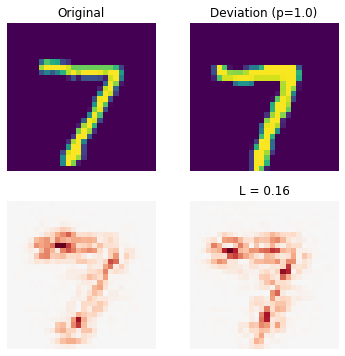

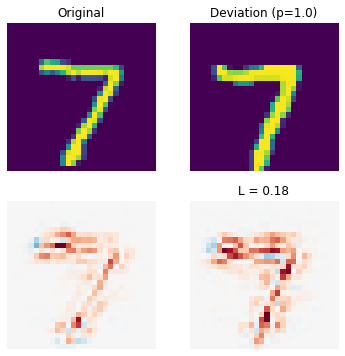

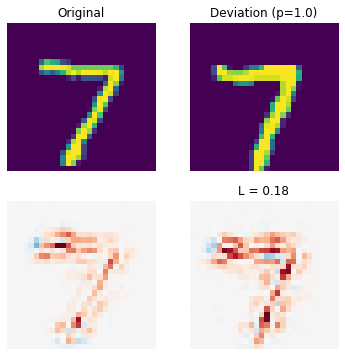

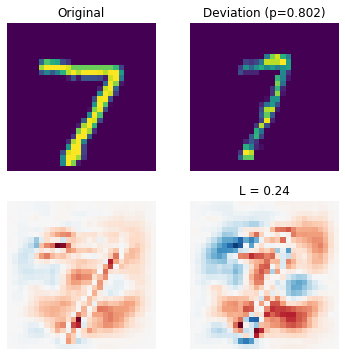

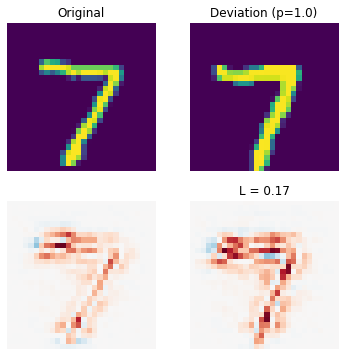

In [540]:
# model_name = 'Saliency'
# model_name = 'Grad*input'
# model_name = 'e-LRP'
# model_name = 'Occlusion'
# model_name = 'Deeplift'

data = cnn_lipschitz_7
d = 7
for model_name in exp_models:
    fig = plot_worst_deviation(data, model_name)
    # fig.text(0.4, 0.004, model_name , fontsize=20, fontstyle='italic')
    fig_name =  'digit_' + str(d) + '_deviation_' + model_name
    fig.savefig(plots_path + fig_name)

## Adding guassian noise

1) https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a

## Define neighbouthood with noisy images

In [284]:
digit = 3
anchor_index = 0
x_test_neighborhood, y_test_neighborhood = neighbourhood_images(x_test, y_test, digit)
print(y_test_neighborhood[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [452]:
def add_guassian_noise(image, mean=0, sigma=0.1):
    gaussian = np.random.normal(mean, sigma, (28, 28)) # np.zeros((28, 28), np.float32)

    noisy_image = np.zeros(image.shape, np.float32)
    noisy_image[:, :, 0] = image[:, :, 0] + gaussian
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

In [545]:
image = x_test_neighborhood[0]

# noisy_image = add_guassian_noise(image, sigma=0.1)
# noisy_image1 = add_guassian_noise(image, sigma=0.125)
# x_noise_neighborhood = np.array([image, noisy_image, noisy_image1 ])
x_noise_neighborhood = np.array([image,
                                 add_guassian_noise(image, sigma=0.075),
                                 add_guassian_noise(image, sigma=0.1),
                                 add_guassian_noise(image, sigma=0.125),
                                 add_guassian_noise(image, sigma=0.15),
                                 add_guassian_noise(image, sigma=0.175),
                                 add_guassian_noise(image, sigma=0.2)  ])
y_noise_neighborhood = y_test_neighborhood[:len(x_noise_neighborhood)]
print(x_noise_neighborhood.shape)
print(y_noise_neighborhood.shape)

(7, 28, 28, 1)
(7, 10)


In [547]:
%%time
""" This block is used for noisy images
"""
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_noise_neighborhood
    ys = y_noise_neighborhood
    
    attributions_sal_noise = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_gradin_noise = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp_noise = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    attributions_occ_noise = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl_noise = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    print('Noisy Digit', digit)
    print ("Done")

Noisy Digit 3
Done
CPU times: user 8.1 s, sys: 501 ms, total: 8.6 s
Wall time: 4.26 s


In [693]:
x_noise_neighborhood_exp = list()
for row in range(0, len(x_noise_neighborhood)):
    exp = dict()
    for key, attr in explanations_noise.items():
        exp[key] = attr[row]
    x_noise_neighborhood_exp.append(exp)
print(x_noise_neighborhood_exp[0].keys())
print(len(x_noise_neighborhood_exp))

dict_keys(['Saliency', 'Grad*input', 'e-LRP', 'Occlusion', 'Deeplift'])
7


In [548]:
exp_attributions_noise = [attributions_sal_noise,
                          attributions_gradin_noise,
                          attributions_elrp_noise,
                          attributions_occ_noise,
                          attributions_dl_noise]
explanations_noise = dict(zip(exp_models, exp_attributions_noise))

In [549]:
cnn_lipschitz_3_noise = lipschitz_estimates_to_dataframe(explanations_noise, x_noise_neighborhood) # Digit 3
# cnn_lipschitz_7_noise = lipschitz_estimates_to_dataframe(explanations_noise, x_noise_neighborhood) # Digit 7

[0.00034453 0.00032744 0.00033185 0.00034955 0.0003288  0.00031289]
[0.08539764 0.0859476  0.08184727 0.07796966 0.0792239  0.07543866]
[0.08539785 0.08594692 0.08184658 0.0779703  0.07922364 0.07543717]
[0.08201528 0.08064491 0.07619622 0.07255271 0.07244799 0.06874646]
[0.08524362 0.08583808 0.08168384 0.07788365 0.07936324 0.07522176]


In [550]:
display(cnn_lipschitz_3_noise.head())

,digit,image_instance,anchor_index,neighborhood_size,image_instance_exp,deviation_indices,lc_coefficents,deviation_image_instances,deviation_image_instance_exp
0,3,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....",0,6,"{'Saliency': [[[0.0007595], [0.00037728], [0.0...","{'Saliency': {'deviation_index': 3}, 'Grad*inp...",{'Saliency': {'lc_coefficent_Saliency': 0.0003...,"{'Saliency': [[[35.], [32.], [35.], [25.], [43...","{'Saliency': [[[0.00114761], [0.00104015], [0...."


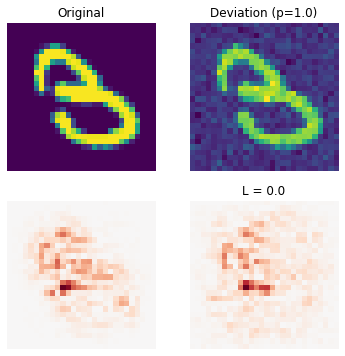

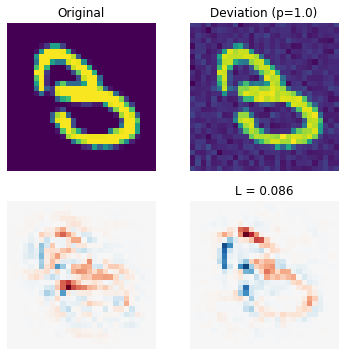

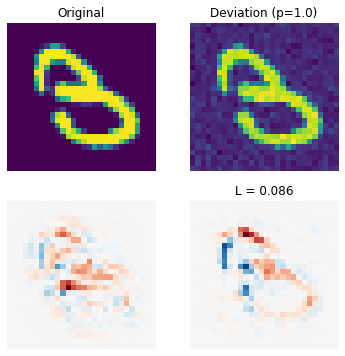

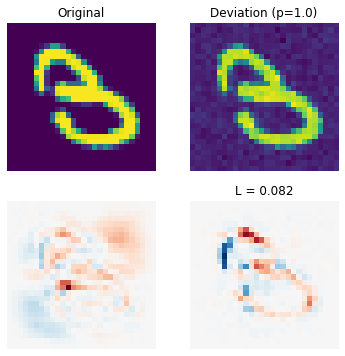

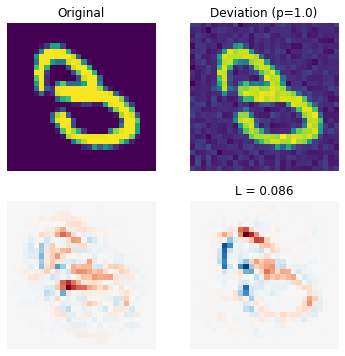

In [580]:
data = cnn_lipschitz_3_noise
d = 3
for model_name in exp_models:
    fig = plot_worst_deviation(data, model_name)
    fig_name =  'noise_' +' digit_' + str(d) + '_deviation_' + model_name
    fig.savefig(plots_path + fig_name)

In [723]:
def lipschitz_ratios(anchor_index, x_neighborhood, x_test_neighborhood_exp):
    
    neighborhood_size = len(x_neighborhood)
    filter_indices = np.arange(0, neighborhood_size)
    filter_indices = np.delete(filter_indices, anchor_index)

    anchorX = x_neighborhood[anchor_index]
    anchorX_exp_dict = x_test_neighborhood_exp[anchor_index]
    anchorX_exp = list(anchorX_exp_dict.values())

    nearby_points = x_neighborhood[filter_indices]
    nearby_points_exp_dict = x_test_neighborhood_exp[filter_indices]
    nearby_points_exp = list(nearby_points_exp_dict[0].values())

    anchorX_norm2 = euclidean_distances(anchorX, nearby_points)
    anchorX_exp_norm2 = euclidean_distances(anchorX_exp, nearby_points_exp)

    anchorX_avg_norm2 = np.divide(anchorX_exp_norm2, anchorX_norm2)
    return anchorX_avg_norm2

In [641]:
# images_noise = dict()
# images_noise.update({'Noise': x_noise_neighborhood[1:]})
# images_noise.update(explanations_noise)
# for index in range(0, len(images_noise)):
#     print('index', index)
#     for i, (key, attr) in enumerate(images_noise.items()):
#         print('col', i)
#         print(key)

CPU times: user 1.05 s, sys: 17 ms, total: 1.07 s
Wall time: 1.06 s


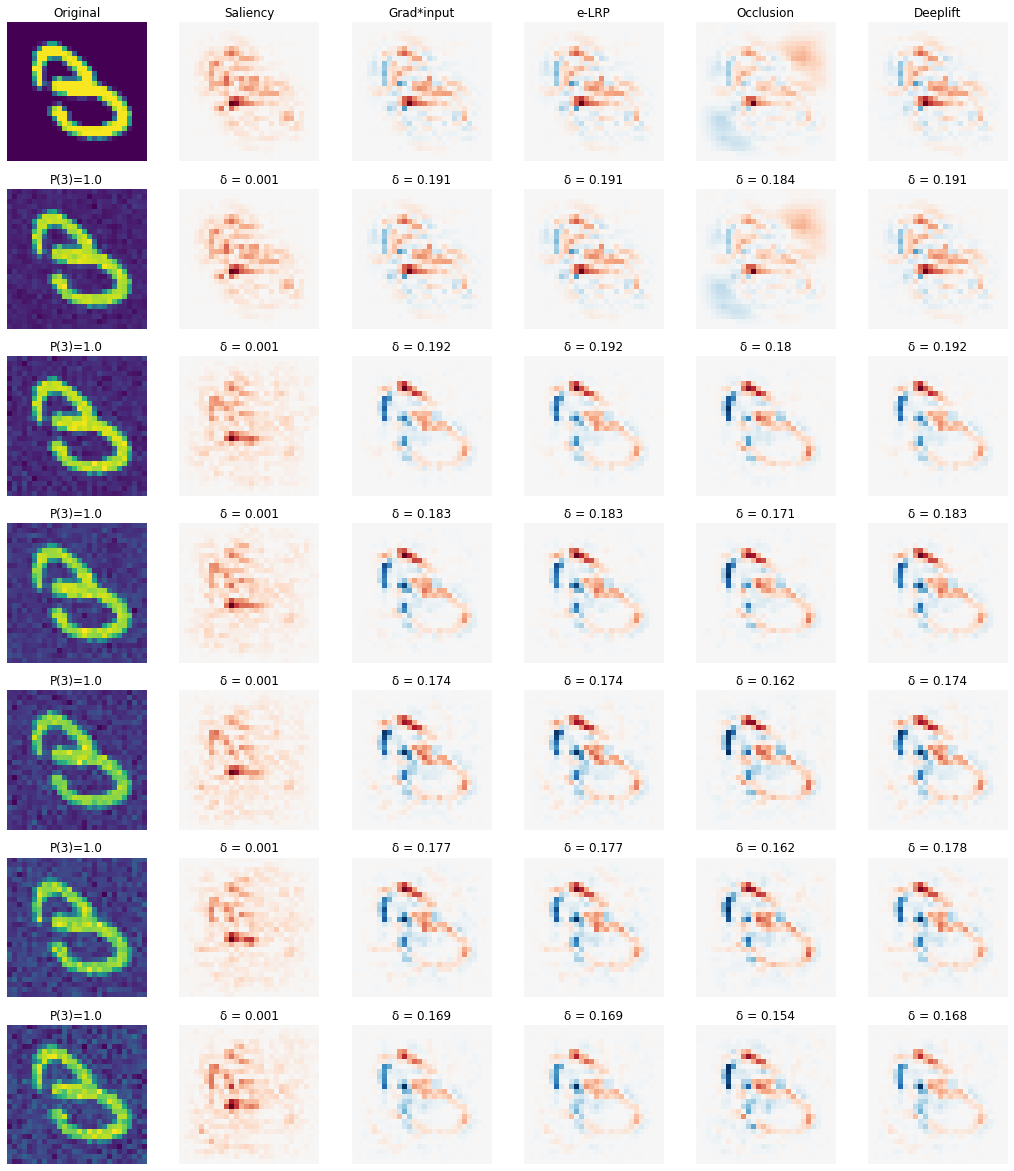

In [764]:
%%time

n_cols = 6
n_rows = len(x_noise_neighborhood) # 7 

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

images = dict()
image_instance = data['image_instance'][0]
images = {'Original': image_instance}
image_instance_exp = data['image_instance_exp'][0]
images.update(image_instance_exp)

for i, (key, instance) in enumerate(images.items()):
    if i == 0:
        plot(instance.reshape(28,28), cmap='viridis', axis=axes[0, 0]).set_title(key)
    else:
        plot(instance.reshape(28,28), axis=axes[0, i]).set_title(key)

images_noise = dict()
images_noise.update({'Noise': x_noise_neighborhood[1:]})
images_noise.update(explanations_noise)

for row in range(1, len(images_noise)+1):
    index = row - 1
    for col, (key, attr) in enumerate(images_noise.items()):
        if key == 'Noise':
            instance = attr[index]
            pred = model.predict(instance.reshape(1, 28, 28, 1))
            axis = plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col])
            pred_prb = str(round(pred[0][pred.argmax()], 4))
            title = 'P(' + str(d) + ')=' + pred_prb
            axis.set_title(title)
            
        else:
            instance = attr[index]
            lc = data['lc_coefficents'][0][key]
            lc_key = 'lc_coefficent_' + key
            dv_key = '& = {}'.format(str(round(lc[lc_key], 2)))
            
            original_point_index = 0
            filtr = [original_point_index, row]
            x_neighborhood = x_noise_neighborhood[filtr]
            x_neighborhood_exp = np.array(x_noise_neighborhood_exp)[filtr]
            anchorX_avg_norm2 = lipschitz_ratios(original_point_index, x_neighborhood, x_neighborhood_exp)
            ratio_key = anchorX_avg_norm2[col-1]
            # https://pythonforundergradengineers.com/unicode-characters-in-python.html
            ratio_key = u'\u03B4 = {}'.format(str(round(ratio_key, 3)))
            plot(instance.reshape(28,28), axis=axes[row, col]).set_title(ratio_key)
            
fig_name =  'lc_ratios_' +' digit_' + str(d)
fig.savefig(plots_path + fig_name)

## Boxplot visualisation of lipschitz estimation on 100 image instances

## Exploring section (LIME, SHAP)
    Does not include in work

In [283]:
epsilon1 = rf_lipschitz.loc[rf_lipschitz['neighborhood_size'] > 0]
epsilon1 = epsilon1[epsilon1['radiuses'] == 1.00]
display(epsilon1.head())

,instance,anchor_x_index,lc_coefficient_lime,x_deviation_index_lime,lc_coefficient_shap,x_deviation_index_shap,radiuses,neighborhood_size
0,"[5.1, 3.4, 1.5, 0.2]",0,2.803608,1,0.203645,11,1.0,8
1,"[5.0, 3.4, 1.6, 0.4]",1,2.803608,0,0.149435,11,1.0,8
2,"[7.2, 3.6, 6.1, 2.5]",2,0.018179,13,0.025685,8,1.0,6
3,"[6.3, 2.7, 4.9, 1.8]",3,0.690476,24,0.496384,4,1.0,10
4,"[6.7, 3.0, 5.0, 1.7]",4,1.002488,7,0.515260,16,1.0,9


In [286]:
epsilon1_lc_lime_aggre = np.mean(epsilon1['lc_coefficient_lime'])
epsilon1_lc_shap_aggre = np.mean(epsilon1['lc_coefficient_shap'])
print("\nLIME, epsilon 1.00, Aggregated L(x) = ", epsilon1_lc_lime_aggre)
print("SHAP, epsilon 1.00, Aggregated L(x) = ", epsilon1_lc_shap_aggre)


LIME, epsilon 1.00, Aggregated L(x) =  0.929153143708511
SHAP, epsilon 1.00, Aggregated L(x) =  0.24586400627509725


In [287]:
lc_lime_df = epsilon1.loc[:, ['lc_coefficient_lime']]
lc_lime_df.rename(columns={'lc_coefficient_lime': 'Lipschitz Estimates'}, inplace=True)
lc_lime_df['method'] = 'LIME'
lc_lime_df['Dataset'] = 'Iris'

lc_shap_df = epsilon1.loc[:, ['lc_coefficient_shap']]
lc_shap_df.rename(columns={'lc_coefficient_shap': 'Lipschitz Estimates'}, inplace=True)
lc_shap_df['method'] = 'SHAP'
lc_shap_df['Dataset'] = 'Iris'

# 5. Visualize Results

### Highest deviation example and corresponding LIME and SHAP examples

In [507]:
print(feature_names)

print('\nAnchor Point in worst deviation case')
print(anchor_point)
print(anchor_point_lime_exp)
print(anchor_point_shap_exp)

print('\nDeviation Point in LIME explanation')
print(deviation_point_lime)
print(deviation_point_lime_exp)

print('\nDeviation Point in SHAP explanation')
print(deviation_point_shap)
print(deviation_point_shap_exp)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Anchor Point in worst deviation case
[5.1 3.4 1.5 0.2]
[0.029, 0.015, 0.428, 0.433]
[0.067, 0.003, 0.294, 0.302]

Deviation Point in LIME explanation
[5.  3.4 1.6 0.4]
[0.004, 0.008, -0.039, -0.07]

Deviation Point in SHAP explanation
[5.5 3.5 1.3 0.2]
[-0.023, 0.003, 0.312, 0.319]


## Final plot to explain deviation as unstability in explanations

### Visualize lipschitz estimations for all test instances

In [505]:
box_plot_df = lc_lime_df.append(lc_shap_df)

In [509]:
filename = 'iris_box_plot_df.csv'
box_plot_df.to_csv(generate_csv_path + filename, index=True)

[None]

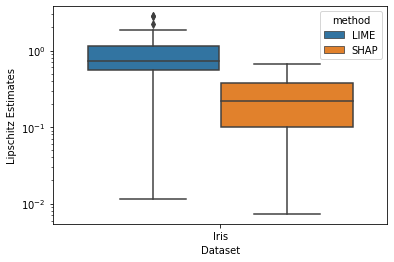

In [503]:
box_plot = sns.boxplot(x="Dataset", y="Lipschitz Estimates", hue="method", data=box_plot_df)
box_plot.set(yscale="log")
# sns.despine(offset=10, trim=True)

### Visualize lipschitz estimations for all test instances from UCI classification datasets

In [517]:
iris_box_plot_df = box_plot_df.copy()
iono_box_plot_df = pd.read_csv(generate_csv_path + "iono_box_plot_df.csv", index_col=0)
glass_box_plot_df = pd.read_csv(generate_csv_path + "glass_box_plot_df.csv", index_col=0)

box_plots = iris_box_plot_df.append(iono_box_plot_df)
box_plots = box_plots.append(glass_box_plot_df)

# display(box_plots.head())
# display(box_plots.tail())

,Lipschitz Estimates,method,Dataset
0,2.803608,LIME,Iris
1,2.803608,LIME,Iris
2,0.018179,LIME,Iris
3,0.690476,LIME,Iris
4,1.002488,LIME,Iris


,Lipschitz Estimates,method,Dataset
38,0.009346,SHAP,Glass
39,0.072976,SHAP,Glass
40,0.034557,SHAP,Glass
41,0.055203,SHAP,Glass
42,0.088517,SHAP,Glass


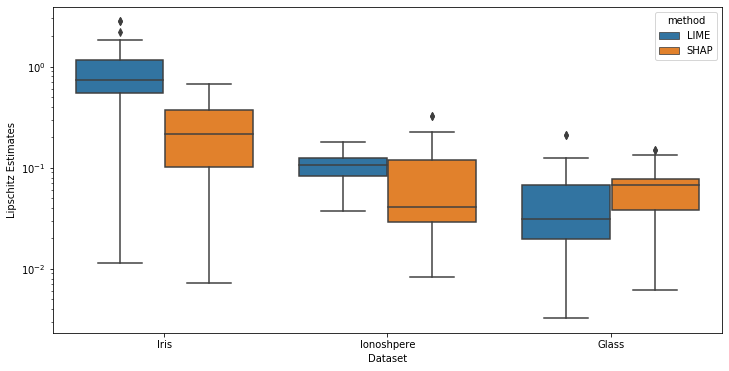

In [527]:
plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x="Dataset", y="Lipschitz Estimates", hue="method", data=box_plots)
box_plot.set(yscale="log")
plt.savefig(plots_path + 'experiments_figure2.png')

### Debuging Space

In [ ]:
""" Use euclidean distance to define neighborhood points
"""
display(X.head())
points = X.values
epsilon = 0.75 * np.sqrt(len(points[0]))

dist = (points[0] - points[1:])**2
dist = np.sum(dist, axis=1)
dist = np.sqrt(dist)
print(dist)
neighborhood_indices = []
for index in range(0, len(dist)):
    if dist[index] < epsilon:
        neighborhood_indices.append(index)
print(neighborhood_indices)

In [662]:
# pixels = x_noise_neighborhood[0].reshape((28, 28))
# plt.imshow(pixels, cmap='Greys')
# plt.show()

# pixels = nearby_points[0].reshape((28, 28))
# plt.imshow(pixels, cmap='Greys')
# plt.show()

# pixels = nearby_points[1].reshape((28, 28))
# plt.imshow(pixels, cmap='Greys')
# plt.show()

In [ ]:
# img = x_test[0]
# img = np.array(img, dtype='float')

# noisy_image = cv2.GaussianBlur(img, (5, 5), 0)
# cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
# noisy_image = noisy_image.reshape((28, 28, 1))
# noisy_image = noisy_image.astype(np.uint8)

# pixels = img.reshape((28, 28))
# plt.imshow(pixels)
# plt.show()

# # noisy_img_clipped = np.clip(noisy_image, 0, 255)
# pixels = noisy_image.reshape((28, 28))
# plt.imshow(pixels)
# plt.show()

In [ ]:
""" Visualising worst case deviation
"""
# # model_name = 'Saliency'
# # model_name = 'Grad*input'
# # model_name = 'e-LRP'
# model_name = 'Occlusion'
# # model_name = 'Deeplift'

# data = cnn_lipschitz_7

# images = dict()
# image_instance = data['image_instance'][0]
# images.update({'Original': image_instance})
# deviation_image_instance = data['deviation_image_instances'][0][model_name]
# images.update({'Deviation': deviation_image_instance})

# image_instance_exp = data['image_instance_exp'][0]
# value = image_instance_exp[model_name]
# images.update({model_name: value})

# deviation_image_instance_exp = data['deviation_image_instance_exp'][0]
# value = deviation_image_instance_exp[model_name]
# new_key = model_name + '_Deviation_Instance'
# images.update({new_key: value})

# print(images.keys())

# n_cols = 2
# n_rows = 2
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

# ax = 0
# for key, instance in images.items():
#     row, col = divmod(ax, 2)
#     if key == 'Original':
#         plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col]).set_title(key)
    
#     elif key ==  'Deviation':
#         pred = model.predict(instance.reshape(1, 28, 28, 1))
#         print(pred)
#         print()
#         print()
#         axis = plot(instance.reshape(28,28), cmap='viridis', axis=axes[row, col])
#         pred_prb = str(round(pred[0][pred.argmax()], 3))
#         title = key + ' (p=' + pred_prb +')'
#         axis.set_title(title)

#     elif key == model_name + '_Deviation_Instance':
#         lc = cnn_lipschitz['lc_coefficents'][0][model_name]
#         lc_key = 'lc_coefficent_' + model_name
#         key = 'L = {}'.format(str(round(lc[lc_key], 2)))
#         plot(instance.reshape(28,28), axis=axes[row, col]).set_title(key)
    
#     else:
#         plot(instance.reshape(28,28), axis=axes[row, col])
#     ax = ax + 1
    
# # for axes in axes.flat:
# #     axes.set(xlabel='x-label', ylabel='y-label')

# # # Hide x labels and tick labels for top plots and y ticks for right plots.
# # for axes in axes.flat:
# #     axes.label_outer()
    
# fig.text(0.4, 0.004, model_name , fontsize=20, fontstyle='italic')
# fig_name = model_name + '_deviation_digit_' + str(digit)
# fig.savefig(plots_path + fig_name)

In [ ]:
# %%time

# n_cols = 6
# n_rows = 1
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
# ax = 0

# image_instance = cnn_lipschitz_7['image_instance'][0]
# images = {'Original': image_instance}
# image_instance_exp = cnn_lipschitz_7['image_instance_exp'][0]
# images.update(image_instance_exp)

# for key, instance in images.items():
#     if ax == 0:
#         plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
#     else:
#         plot(instance.reshape(28,28), axis=axes[ax]).set_title(key)
#     ax = ax + 1
    

# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
# ax = 0

# deviation_image_instance = cnn_lipschitz_7['deviation_image_instance'][0]
# images = {'Deviation': deviation_image_instance}
# deviation_image_instance_exp = cnn_lipschitz_7['deviation_image_instance_exp'][0]
# images.update(deviation_image_instance_exp)

# for key, instance in images.items():
#     if ax == 0:
#         plot(instance.reshape(28,28), cmap='viridis', axis=axes[ax]).set_title(key)
#     else:
#         lc = cnn_lipschitz_7['lc_coefficents'][0][key]
#         lc_key = 'lc_coefficent_' + key
#         dv_key = 'L = {}'.format(str(round(lc[lc_key], 2)))
#         plot(instance.reshape(28,28), axis=axes[ax]).set_title(dv_key)
#     ax = ax + 1